In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf

from datetime import datetime

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
from calculate_tau import func_single_exp_monkey, fit_single_exp
from calculate_acf import acf_sttc
from spike_train_utils import bin_spike_train_fixed_len
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
save_folder = project_folder_path + 'results\\synthetic\\dataset\\'
fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper_reduce\\'

#### Load spike trains

In [5]:
spike_trains_10min = np.load(save_folder + 'spike_trains_tau100ms_alpha0_3_fr3_5hz_len600sec_1000.npy', allow_pickle=True)
print(f'n spike trains {len(all_spike_trains)}, len {all_spike_trains[0][-1]/1000}')

duration_ms = 600 * 1000
target_fr_hz = 3.5
target_tau_ms = 100

fs = 1000

n spike trains 1000, len 599.4657698736828


In [17]:
def subsample_spike_trains(spike_trains, durations, n_segments_per_train=1, random_seed=42):
    """
    Subsample segments from long spike trains.

    Parameters:
        spike_trains (list of np.array): List of spike trains (spike times in seconds).
        durations (list of float): List of durations to subsample (in seconds).
        n_segments_per_train (int): Number of segments to extract per train per duration.
        random_seed (int): For reproducibility.

    Returns:
        dict: {duration: list of lists of spike times}, one list per segment.
    """
    np.random.seed(random_seed)
    max_time = 600*1000  # seconds (10 minutes)
    result = {d: [] for d in durations}

    for spikes in spike_trains:
        for duration in durations:
            for _ in range(n_segments_per_train):
                max_start = max_time - duration
                if max_start <= 0:
                    raise ValueError(f"Duration {duration}s is too long for spike train of {max_time}s.")
                start = np.random.uniform(0, max_start)
                end = start + duration
                mask = (spikes >= start) & (spikes < end)
                segment = spikes[mask] - start  # shift to start at 0
                result[duration].append(segment)

    return result

In [39]:
# Suppose you already have 1000 spike trains:
# Each is a NumPy array of spike times in seconds (e.g., [0.2, 0.33, ..., 599.8])
# They are stored in a list called `spike_trains_10min`

durations = [1050, 2000, 5000, 10000, 20000, 30000, 60000, 120000, 300000] # durations in ms
subsampled_data = subsample_spike_trains(spike_trains_10min, durations, n_segments_per_train=1)

# Example: Get the 1s segments
segments_1s = subsampled_data[1050]  # list of arrays, each 1s long

# Check how many segments were generated
print(f"Generated {len(segments_1s)} 1-second segments")

Generated 1000 1-second segments


#### Calculate tau

In [40]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

fs = 1000
bin_size = int(50 * (fs / 1000))
sttc_dt = int(25 * (fs / 1000))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [50]:
def estimate_tau_acf_full(spike_times, duration_ms):
    binned_spike_train = bin_spike_train_fixed_len([int(spike) for spike in spike_times],
                                               bin_size, fs, duration_ms,
                                               verbose_=False)
    spike_train_binned_acf = acf(binned_spike_train, nlags=n_lags)
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(spike_train_binned_acf,
                                                                              start_idx_=1, exp_fun_=func_single_exp_monkey)
    return tau * bin_size, fit_r_squared

def estimate_tau_isttc_full(spike_times, duration_ms):
    spike_train_int = np.asarray([int(spike) for spike in spike_times])
    spike_train_acf = acf_sttc(spike_train_int, n_lags, bin_size, sttc_dt, duration_ms, verbose_=False)
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(spike_train_acf,
                                                                          start_idx_=1, exp_fun_=func_single_exp_monkey)
    
    return tau * bin_size, fit_r_squared

In [51]:
def evaluate_methods(subsampled_data, true_tau):
    """
    Evaluate both estimation methods on subsampled spike trains.

    Parameters:
        subsampled_data (dict): {duration: list of spike time arrays}
        true_tau (float): Ground truth time constant (ms or s, match your methods)

    Returns:
        pd.DataFrame: Rows with duration, method, estimated_tau, error
    """
    results = []

    for duration, segments in subsampled_data.items():
        for i, spikes in enumerate(segments):
            tau1, fit_r_squared1 = estimate_tau_acf_full(spikes, duration)
            tau2, fit_r_squared2 = estimate_tau_isttc_full(spikes, duration)

            results.append({
                "duration": duration,
                "method": "acf_full",
                "estimated_tau": tau1,
                "error": tau1 - true_tau,
                'r_squared': fit_r_squared1
            })
            results.append({
                "duration": duration,
                "method": "isttc_full",
                "estimated_tau": tau2,
                "error": tau2 - true_tau,
                'r_squared': fit_r_squared2
            })

    df = pd.DataFrame(results)
    return df

In [28]:
def compute_rmse_by_duration(df):
    """
    Compute RMSE of estimated tau per duration and method.

    Returns:
        pd.DataFrame with columns: duration, method, rmse
    """
    rmse_df = (
        df.groupby(["duration", "method"])["error"]
        .apply(lambda x: np.sqrt(np.mean(x**2)))
        .reset_index(name="rmse")
    )
    return rmse_df

In [29]:
def plot_rmse_vs_duration(rmse_df):
    """
    Plot RMSE vs. duration for each method.
    """
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=rmse_df, x="duration", y="rmse", hue="method", marker="o")

    plt.xscale("log")
    plt.xlabel("Duration (s, log scale)")
    plt.ylabel("RMSE of Estimated Tau")
    plt.title("RMSE vs. Duration for Each Estimation Method")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()

In [52]:
true_tau = 100.0  # set your actual ground truth value in the same units as your methods
evaluation_df = evaluate_methods(subsampled_data, true_tau)

C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipochino\AppData\Local\anaconda3\envs\isttc\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


In [53]:
evaluation_df

,duration,method,estimated_tau,error,r_squared
0,1050,acf_full,2.671650,-97.328350,-7.069059e-10
1,1050,isttc_full,2.293994,-97.706006,-1.050904e-10
2,1050,acf_full,1.878468,-98.121532,-6.748113e-11
3,1050,isttc_full,214.558629,114.558629,3.649218e-02
4,1050,acf_full,29.613523,-70.386477,8.989645e-04
...,...,...,...,...,...
17995,300000,isttc_full,80.532985,-19.467015,8.705935e-01
17996,300000,acf_full,146.677301,46.677301,7.648223e-01
17997,300000,isttc_full,141.653957,41.653957,8.468657e-01
17998,300000,acf_full,72.788263,-27.211737,8.817247e-01


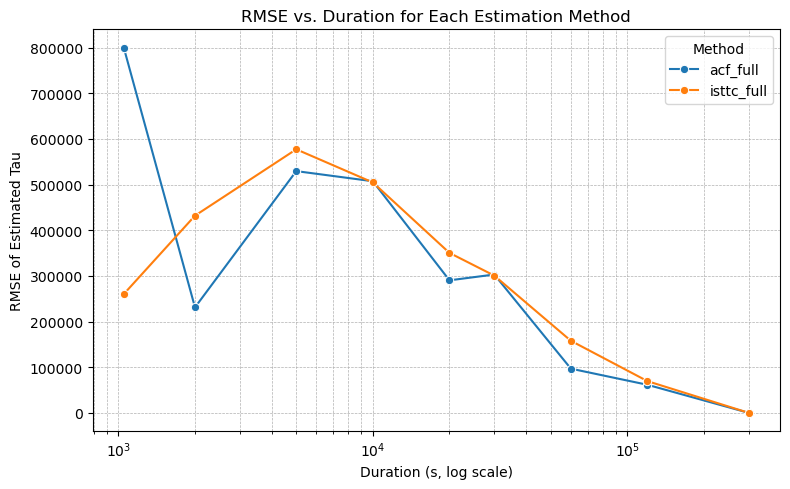

In [54]:
rmse_df = compute_rmse_by_duration(evaluation_df)
plot_rmse_vs_duration(rmse_df)

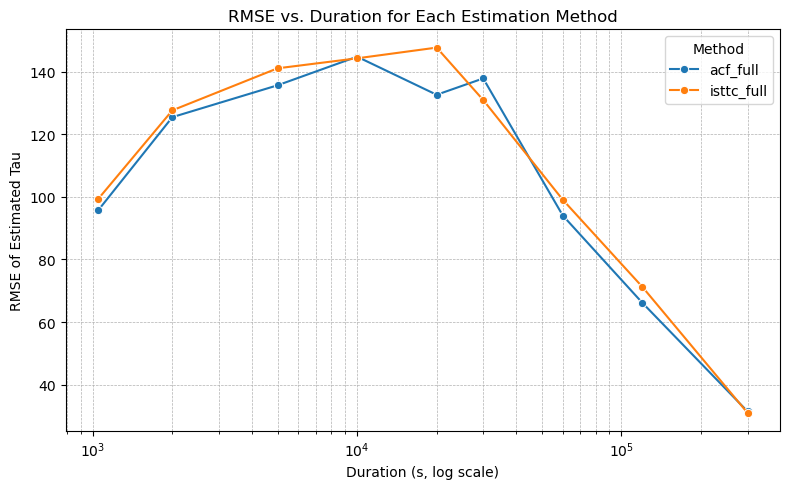

In [55]:
rmse_df = compute_rmse_by_duration(evaluation_df.query('estimated_tau <= 1000'))
plot_rmse_vs_duration(rmse_df)

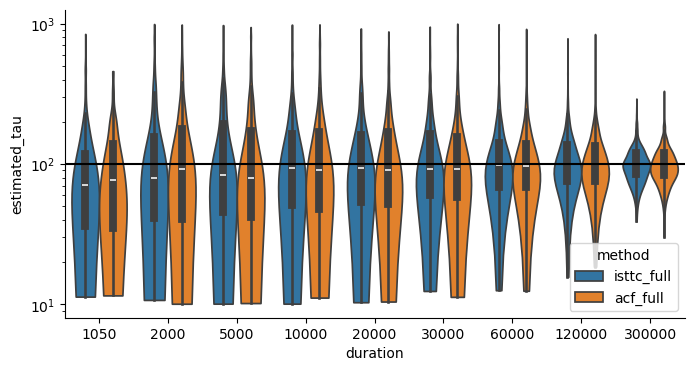

In [64]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='duration', y='estimated_tau', data=evaluation_df.query('estimated_tau <= 1000 and estimated_tau > 10'), 
               hue='method', cut=0,  density_norm='width')
axes.set_yscale('log')
axes.axhline(y=100, color='k')

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

In [65]:
evaluation_df['error_abs'] = np.abs(evaluation_df['error'])

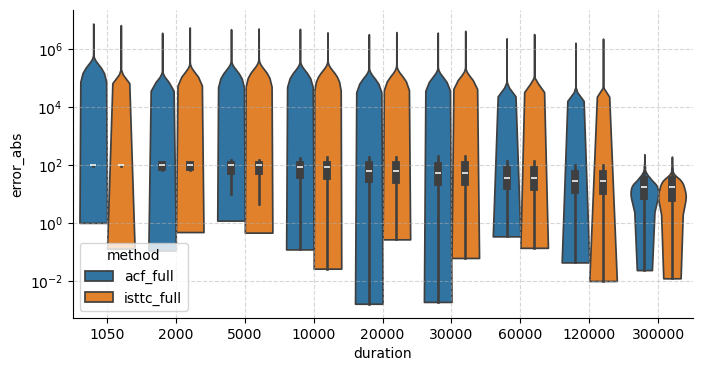

In [69]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='duration', y='error_abs', data=evaluation_df, 
               hue='method', cut=0,  density_norm='width')
axes.set_yscale('log')
axes.grid(True, linestyle='--', alpha=0.5)

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

In [70]:
evaluation_df.groupby(by=['method', 'duration'], as_index=False).median()

,method,duration,estimated_tau,error,r_squared,error_abs
0,acf_full,1050,2.410848,-97.589152,-1.514566e-12,97.785411
1,acf_full,2000,4.292671,-95.707329,2.843587e-02,96.945409
2,acf_full,5000,27.677315,-72.322685,1.454547e-01,95.538643
3,acf_full,10000,64.270783,-35.729217,2.635266e-01,82.770964
4,acf_full,20000,79.682268,-20.317732,3.848269e-01,62.986284
5,acf_full,30000,86.593070,-13.406930,4.673280e-01,53.067573
6,acf_full,60000,96.196148,-3.803852,6.381535e-01,35.765461
7,acf_full,120000,100.725805,0.725805,7.823595e-01,28.263113
8,acf_full,300000,99.818843,-0.181157,8.910708e-01,17.604477
9,isttc_full,1050,2.701256,-97.298744,-1.110223e-16,97.414172


In [75]:
def plot_estimated_tau_vs_duration(df):
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x="duration", y="estimated_tau", hue="method", marker="o")

    plt.xscale("log")
    plt.xlabel("Duration (s, log scale)")
    plt.ylabel("Estimated Time Constant (τ)")
    plt.title("Estimated τ vs. Duration by Method")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()

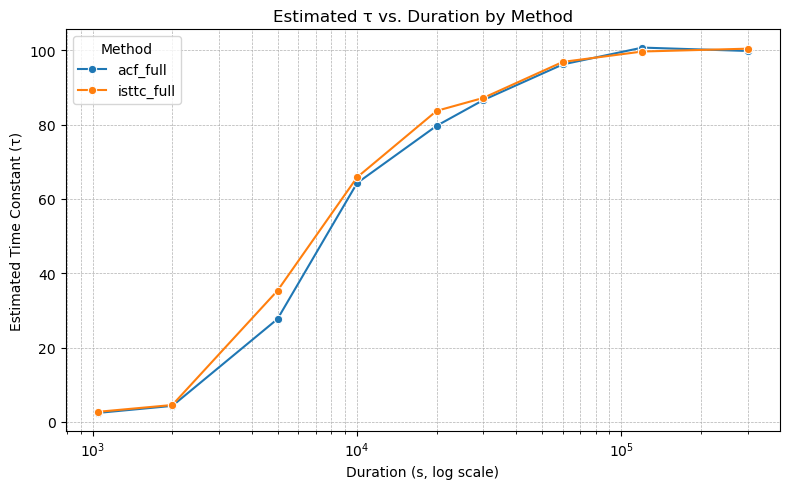

In [76]:
plot_estimated_tau_vs_duration(evaluation_df.groupby(by=['method', 'duration'], as_index=False).median())